# Tarefa 2-2: Rede Neural de Duas Camadas

Antes de começar, coloque seu nome e RA no seguinte formato

: Nome SOBRENOME, #000000   //   e.g.) Jurandy ALMEIDA, #123456

**Sua Resposta:**   
Gabriel BELLON DE CARVALHO, #802430


# Código de Configuração
Antes de começarmos, precisamos executar algum código padrão para configurar nosso ambiente. Você precisará executar novamente este código de configuração sempre que iniciar o notebook.

Primeiro, execute esta célula para carregar a extensão [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload). Isso nos permite editar arquivos de origem `.py` e reimportá-los para o notebook para uma experiência de edição e depuração perfeita.

In [2]:
%load_ext autoreload
%autoreload 2

### Configuração do Google Colab
Em seguida, precisamos executar alguns comandos para configurar nosso ambiente no Google Colab. Se você estiver executando este notebook em uma máquina local, pode pular esta seção.

Execute a seguinte célula para montar seu Google Drive. Siga o link, entre na sua conta do Google (a mesma conta que você usou para armazenar este notebook!) E copie o código de autorização na caixa de texto que aparece abaixo.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Agora lembre-se do caminho em seu Google Drive onde você carregou este notebook, preencha-o abaixo. Se tudo estiver funcionando corretamente, a execução da célula a seguir deve imprimir os nomes dos arquivos da tarefa:

```
['classificador_linear.ipynb', 'classificador_linear.py', 'rede_duas_camadas.ipynb', 'rede_duas_camadas.py', 'rv', 't2_auxiliares.py']
```

In [4]:
import os

# TODO: Preencha o caminho do Google Drive para onde você carregou a tarefa
# Exemplo: se você criar uma pasta RV-2022-2 e colocar todos os arquivos na pasta T2, então 'RV-2022-2/T2'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'RV-2022-2/T2'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'RV-2022-2/T2/T2'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['t2_auxiliares.py', 'rv', '__pycache__', 'rede_duas_camadas.py', 'melhor_modelo_rn.pt', 'Gabriel_802430_T2.zip', 'classificador_linear.py', 'melhor_modelo_svm.pt', 'melhor_modelo_softmax.pt', 'classificador_linear.ipynb', 'rede_duas_camadas.ipynb']


Depois de montar com sucesso seu Google Drive e localizar o caminho para esta tarefa, execute a seguinte célula para permitir a importação dos arquivos `.py` desta tarefa. Se funcionar corretamente, deve imprimir a mensagem:

```
Olá do rede_duas_camadas.py!
Olá do t2_auxiliares.py!
```

bem como a última hora de edição do arquivo `rede_duas_camadas.py`.


In [ ]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

from rede_duas_camadas import ola_rede_duas_camadas
ola_rede_duas_camadas()

from t2_auxiliares import ola_auxiliar
ola_auxiliar()

rede_duas_camadas_path = os.path.join(GOOGLE_DRIVE_PATH, 'rede_duas_camadas.py')
rede_duas_camadas_edit_time = time.ctime(os.path.getmtime(rede_duas_camadas_path))
print('rede_duas_camadas.py última edição em %s' % rede_duas_camadas_edit_time)

Olá do rede_duas_camadas.py!


## Diversos

Execute algum código de configuração para este notebook: Importe alguns pacotes úteis e aumente o tamanho padrão dos gráficos.


In [ ]:
import rv
import torch
import matplotlib.pyplot as plt
import statistics
import random
import time
%matplotlib inline


plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Usaremos GPUs para acelerar nossa computação neste notebook. Execute esta célula para certificar-se de que as GPUs estão habilitadas:

In [ ]:
if torch.cuda.is_available:
  print('Pronto para continuar!')
else:
  print('Por favor, habilite a GPU em Edit -> Notebook Settings.')

# Implementando uma Rede Neural
Neste exercício, iremos desenvolver uma rede neural com camadas totalmente conectadas para realizar a classificação e testá-la no conjunto de dados CIFAR-10.

Treinamos a rede com uma função de perda softmax e regularização L2 nas matrizes de peso. A rede usa uma não-linearidade ReLU após a primeira camada totalmente conectada.

Em outras palavras, a rede possui a seguinte arquitetura:

  entrada -  camada totalmente conectada - ReLU - camada totalmente conectada - softmax

As saídas da segunda camada totalmente conectada são as pontuações de cada classe.

**Nota**: Quando você implementar a regularização sobre W, **por favor, NÃO multiplique o termo de regularização por 1/2** (sem coeficiente).


## Brinque com dados de exemplo

As entradas para nossa rede serão um lote de $N$ (`num_amostras`) vetores $D$-dimensionais (`tamanho_entrada`); a camada oculta terá $H$ unidades ocultas (`tamanho_oculta`), e iremos prever pontuações de classificação para $C$ categorias (`num_categorias`). Isso significa que os pesos e vieses aprendíveis da rede terão as seguintes formas:

* W1: Pesos da primeira camada; tem shape $(D, H)$
* b1: Vieses da primeira camada; tem shape $(H,)$
* W2: Pesos da segunda camada; tem shape $(H, C)$
* b2: Vieses da segunda camada; tem shape $(C,)$

Usaremos a função `t2_auxiliares.gerar_dados_de_exemplo` para gerar pesos aleatórios para um pequeno modelo de exemplo enquanto implementamos o modelo.


### Passo para frente: calcule saídas
Como no exercício de Classificadores Lineares, queremos escrever uma função que tome como entrada os pesos do modelo e um lote de imagens e rótulos, e retorne a perda e o gradiente da perda em relação a cada parâmetro do modelo.

No entanto, em vez de tentar implementar a função inteira de uma vez, usaremos uma abordagem em estágios e pediremos que você implemente os passos para frente e para trás por completo, um de cada vez.

Primeiro, implementaremos o passo para frente na rede que usa os pesos e vieses para calcular as pontuações de todas as entradas em `rn_passo_para_frente`.


Calcule as pontuações e compare com a resposta. A diferença entre elas deve ser menor que 1e-10.


In [ ]:
import rv
from t2_auxiliares import gerar_dados_de_exemplo
from rede_duas_camadas import rn_passo_para_frente

rv.redefinir_semente(0)
exemplo_X, exemplo_y, params = gerar_dados_de_exemplo()

# SUA_VEZ: Implemente a parte de cálculo de pontuação de rn_passo_para_frente
pontuacoes, _ = rn_passo_para_frente(params, exemplo_X)
print('Suas pontuacoes:')
print(pontuacoes)
print(pontuacoes.dtype)
print()
print('pontuacoes corretas:')
pontuacoes_corretas = torch.tensor([
        [ 9.7003e-08, -1.1143e-07, -3.9961e-08],
        [-7.4297e-08,  1.1502e-07,  1.5685e-07],
        [-2.5860e-07,  2.2765e-07,  3.2453e-07],
        [-4.7257e-07,  9.0935e-07,  4.0368e-07],
        [-1.8395e-07,  7.9303e-08,  6.0360e-07]], dtype=torch.float32, device=pontuacoes.device)
print(pontuacoes_corretas)
print()

# A diferença deve ser muito pequena. Conseguimos < 1e-10
pontuacoes_dif = (pontuacoes - pontuacoes_corretas).abs().sum().item()
print('Diferença entre suas pontuações e as pontuações corretas: %.2e' % pontuacoes_dif)

Suas pontuacoes:
tensor([[ 9.7003e-08, -1.1143e-07, -3.9961e-08],
        [-7.4297e-08,  1.1502e-07,  1.5685e-07],
        [-2.5860e-07,  2.2765e-07,  3.2453e-07],
        [-4.7257e-07,  9.0935e-07,  4.0368e-07],
        [-1.8395e-07,  7.9303e-08,  6.0360e-07]], device='cuda:0')
torch.float32

pontuacoes corretas:
tensor([[ 9.7003e-08, -1.1143e-07, -3.9961e-08],
        [-7.4297e-08,  1.1502e-07,  1.5685e-07],
        [-2.5860e-07,  2.2765e-07,  3.2453e-07],
        [-4.7257e-07,  9.0935e-07,  4.0368e-07],
        [-1.8395e-07,  7.9303e-08,  6.0360e-07]], device='cuda:0')

Diferença entre suas pontuações e as pontuações corretas: 2.24e-11


### Passo para frente: cálculo da perda
Agora, implementaremos a primeira parte de `rn_frente_tras` que calcula a perda de dados e de regularização.

Para a perda de dados, usaremos a perda softmax. Para a perda de regularização usaremos a regularização L2 nas matrizes de peso `W1` e` W2`; não aplicaremos perda de regularização aos vetores de viés `b1` e` b2`.

Primeiro, vamos executar o seguinte para verificar sua implementação.

Calculamos a perda para os dados de exemplo e comparamos com a resposta calculada por nossa implementação. A diferença entre a perda correta e a calculada deve ser menor que `1e-4`.

In [ ]:
import rv
from t2_auxiliares import gerar_dados_de_exemplo
from rede_duas_camadas import rn_frente_tras

rv.redefinir_semente(0)
exemplo_X, exemplo_y, params = gerar_dados_de_exemplo()

# SUA_VEZ: Implemente a parte de cálculo de perda de rn_frente_tras
perda, _ = rn_frente_tras(params, exemplo_X, exemplo_y, reg=0.05)
print('Sua perda: ', perda.item())
perda_correta = 1.0986121892929077
print('Perda correta: ', perda_correta)
dif = (perda_correta - perda).item()

# deve ser muito pequena, conseguimos < 1e-4
print('Diferença: %.4e' % dif)

Sua perda:  1.0986121892929077
Perda correta:  1.0986121892929077
Diferença: 0.0000e+00


### Passo para trás
Agora implemente o passo para trás para toda a rede em `rn_frente_tras`.

Depois de fazer isso, usaremos a verificação de gradiente numérico para ver se o gradiente analítico calculado por nosso passo para trás corresponde a um gradiente numérico.

Usaremos as funções `rv.grad.calcular_gradiente_numerico` e `rv.grad.erro_rel` para ajudar na verificação do gradiente numérico. Podemos aprender mais sobre essas funções usando o comando `help`:

In [ ]:
help(rv.grad.calcular_gradiente_numerico)
print('-' * 80)
help(rv.grad.erro_rel)

Help on function calcular_gradiente_numerico in module rv.grad:

calcular_gradiente_numerico(f, x, h=1e-07)
    Calcula o gradiente numérico de f em x usando uma aproximação de 
    diferenças finitas. Usamos a diferença centrada:
    
    df    f(x + h) - f(x - h)
    -- ~= -------------------
    dx           2 * h
    
    Entrada:
    - f: Uma função que recebe a um tensor do torch e retorna um escalar do torch 
    - x: Um tensor do torch contendo o ponto no qual calcular o gradiente numérico
    - h: epsilon usado no cálculo da diferença finita
    
    Retorno:
    - grad: Um tensor de mesmo shape que x contendo o gradiente de f em x

--------------------------------------------------------------------------------
Help on function erro_rel in module rv.grad:

erro_rel(x, y, eps=1e-10)
    Calcula o erro relativo entre um par de tensores x e y,
    que é definido como:
    
                           max_i |x_i - y_i]|
    erro_rel(x, y) = -------------------------------
        

Agora vamos calcular o gradiente da perda em relação às variáveis `W1`, `b1`, `W2` e `b2`. Agora que você (assim espera!) tem um passo para frente implementado corretamente, pode depurar seu passo para trás usando uma verificação de gradiente numérica.

Você deve ver erros relativos menores que `1e-4` para todos os parâmetros.

In [ ]:
import rv
from t2_auxiliares import gerar_dados_de_exemplo
from rede_duas_camadas import rn_frente_tras

rv.redefinir_semente(0)

reg = 0.05
exemplo_X, exemplo_y, params = gerar_dados_de_exemplo(dtype=torch.float64)

# SUA_VEZ: Implemente a parte de cálculo de gradiente de rn_frente_tras.
# Para você implementar a parte de cálculo do gradiente, pode ser necessário
# implementar também a saída da camada oculta em rn_passo_para_frente.
perda, grads = rn_frente_tras(params, exemplo_X, exemplo_y, reg=reg)

for nome_param, grad in grads.items():
  param = params[nome_param]
  f = lambda w: rn_frente_tras(params, exemplo_X, exemplo_y, reg=reg)[0]
  grad_numerico = rv.grad.calcular_gradiente_numerico(f, param)
  erro = rv.grad.erro_rel(grad, grad_numerico)
  print('%s erro relativo máximo: %e' % (nome_param, erro))

W2 erro relativo máximo: 1.058379e-06
b2 erro relativo máximo: 3.803171e-09
W1 erro relativo máximo: 1.494315e-06
b1 erro relativo máximo: 8.860777e-06


### Treine a rede
Para treinar a rede, usaremos a descida de gradiente estocástico (do inglês, *stochastic gradient descent* -- SGD), semelhante aos classificadores SVM (do inglês, *support vector machine*) e Softmax.

Observe a função `rn_treinar` e preencha as seções que faltam para implementar o procedimento de treinamento. Isso deve ser muito semelhante ao procedimento de treinamento usado para os classificadores SVM e Softmax.

Você também terá que implementar `rn_prever`, pois o processo de treinamento realiza previsões periodicamente para manter o controle da acurácia ao longo do tempo, enquanto a rede treina.

Depois de implementar o método, execute o código abaixo para treinar uma rede de duas camadas em dados de exemplo. Sua perda final de treinamento deve ser inferior a 1.0.

Perda final de treinamento:  0.5211756229400635


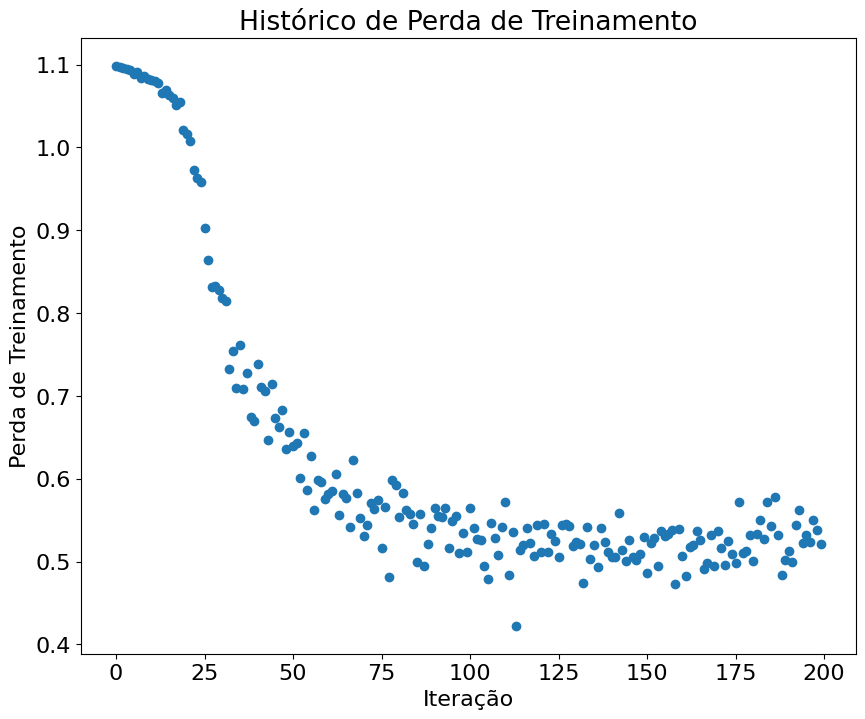

In [ ]:
import rv
from t2_auxiliares import gerar_dados_de_exemplo
from rede_duas_camadas import rn_frente_tras, rn_treinar, rn_prever

rv.redefinir_semente(0)
exemplo_X, exemplo_y, params = gerar_dados_de_exemplo()

# SUA VEZ: Implemente a função rn_treinar.
# Você também pode precisar verificar a função rn_prever (o "func_prev").
estats = rn_treinar(params, rn_frente_tras, rn_prever, exemplo_X, exemplo_y,
                    exemplo_X, exemplo_y, taxa_aprendizagem=1e-1, reg=1e-6,
                    num_iters=200, verbose=False)

print('Perda final de treinamento: ', estats['historico_perda'][-1])

# plota o histórico de perdas
plt.plot(estats['historico_perda'], 'o')
plt.xlabel('Iteração')
plt.ylabel('Perda de Treinamento')
plt.title('Histórico de Perda de Treinamento')
plt.show()

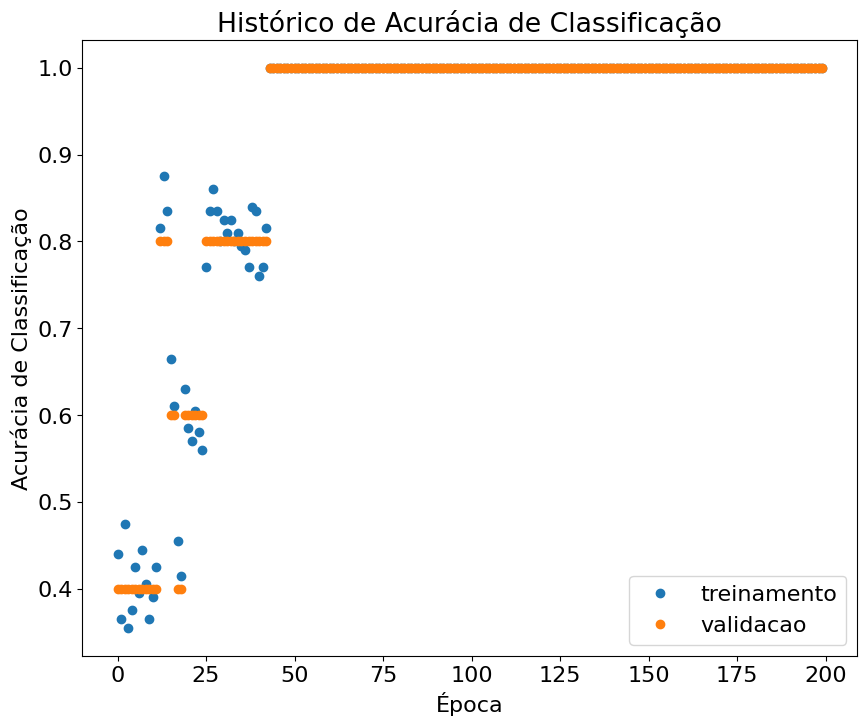

In [ ]:
# Plota a função de perda e as acurácias de treinamento / validação
plt.plot(estats['historico_acc_treinamento'], 'o', label='treinamento')
plt.plot(estats['historico_acc_validacao'], 'o', label='validacao')
plt.title('Histórico de Acurácia de Classificação')
plt.xlabel('Época')
plt.ylabel('Acurácia de Classificação')
plt.legend()
plt.show()

## Testando nossa RN em um conjunto de dados real: CIFAR-10
Agora que você implementou uma rede de duas camadas que passa nas verificações de gradiente e trabalha com dados de exemplo, é hora de carregar os dados do conjunto CIFAR-10 para que possamos usá-los para treinar um classificador em um conjunto de dados real.

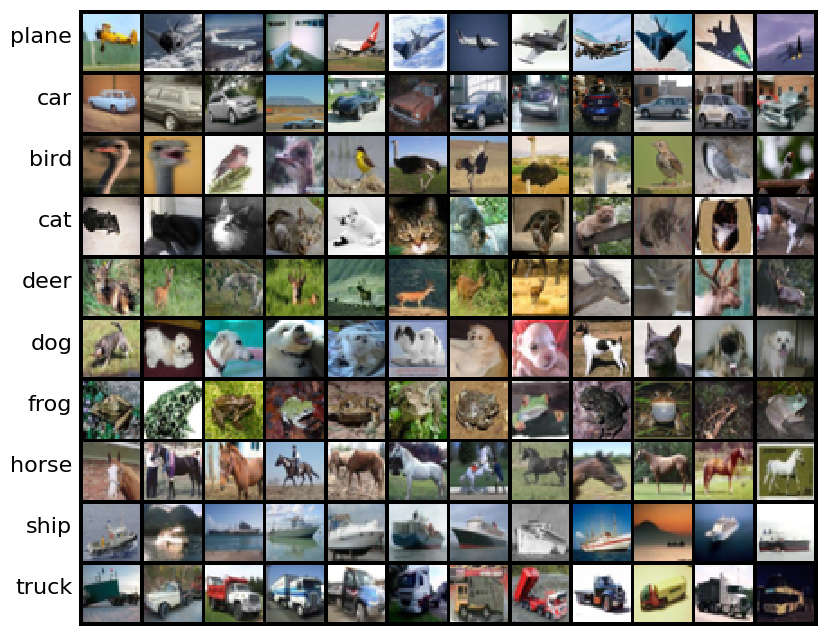

Dados de treinamento (shape):  torch.Size([40000, 3072])
Rótulos de treinamento (shape):  torch.Size([40000])
Dados de validação (shape):  torch.Size([10000, 3072])
Rótulos de valicação (shape):  torch.Size([10000])
Dados de teste (shape):  torch.Size([10000, 3072])
Rótulos de teste (shape):  torch.Size([10000])


In [ ]:
import rv

# Chame a rotina acima para obter nossos dados.
rv.redefinir_semente(0)
dic_dados = rv.data.preprocessar_cifar10(dtype=torch.float64)
print('Dados de treinamento (shape): ', dic_dados['X_treino'].shape)
print('Rótulos de treinamento (shape): ', dic_dados['y_treino'].shape)
print('Dados de validação (shape): ', dic_dados['X_val'].shape)
print('Rótulos de valicação (shape): ', dic_dados['y_val'].shape)
print('Dados de teste (shape): ', dic_dados['X_teste'].shape)
print('Rótulos de teste (shape): ', dic_dados['y_teste'].shape)

### Envolva todas as funções em uma Classe
Usaremos a classe `RedeDuasCamadas` para representar instâncias da nossa rede. Os parâmetros de rede são armazenados na variável de instância `self.params`, onde as chaves são nomes de parâmetros e os valores são tensores do PyTorch.



### Treine uma rede
Para treinar nossa rede usaremos SGD. Além disso, conforme a otimização prossegue, ajustaremos a taxa de aprendizagem de acordo com um decaimento exponencial. Após cada época, reduziremos a taxa de aprendizagem, multiplicando-a por uma taxa de decaimento.

In [ ]:
import rv
from rede_duas_camadas import RedeDuasCamadas

tamanho_entrada = 3 * 32 * 32
tamanho_oculta = 36
num_categorias = 10

# Ajusta a semente aleatória antes de gerar um conjunto de parâmetros
rv.redefinir_semente(0)
rede = RedeDuasCamadas(tamanho_entrada, tamanho_oculta, num_categorias, dtype=dic_dados['X_treino'].dtype, device=dic_dados['X_treino'].device)

# Treina a rede
estats = rede.treinar(dic_dados['X_treino'], dic_dados['y_treino'],
                      dic_dados['X_val'], dic_dados['y_val'],
                      num_iters=500, tamanho_lote=1000,
                      taxa_aprendizagem=1e-2, decaimento_taxa_aprendizagem=0.95,
                      reg=0.25, verbose=True)

# Prevê no conjunto de validação
y_prev_validacao = rede.prever(dic_dados['X_val'])
acc_validacao = 100.0 * (y_prev_validacao == dic_dados['y_val']).double().mean().item()
print('Acurácia de validação: %.2f%%' % acc_validacao)

iteração 0 / 500: perda 2.302864
iteração 100 / 500: perda 2.302695
iteração 200 / 500: perda 2.302669
iteração 300 / 500: perda 2.302552
iteração 400 / 500: perda 2.302571
Acurácia de validação: 9.77%


### Depure o treinamento
Com os parâmetros padrão que fornecemos acima, você deve obter uma acurácia inferior a 10% no conjunto de validação. Isso não é muito bom.

Uma estratégia para obter uma visão do que está errado é plotar a função de perda e as acurácias nos conjuntos de treinamento e de validação durante a otimização.

Outra estratégia é visualizar os pesos que foram aprendidos na primeira camada da rede. Na maioria das redes neurais treinadas em dados visuais, os pesos da primeira camada normalmente mostram alguma estrutura visível quando visualizada.

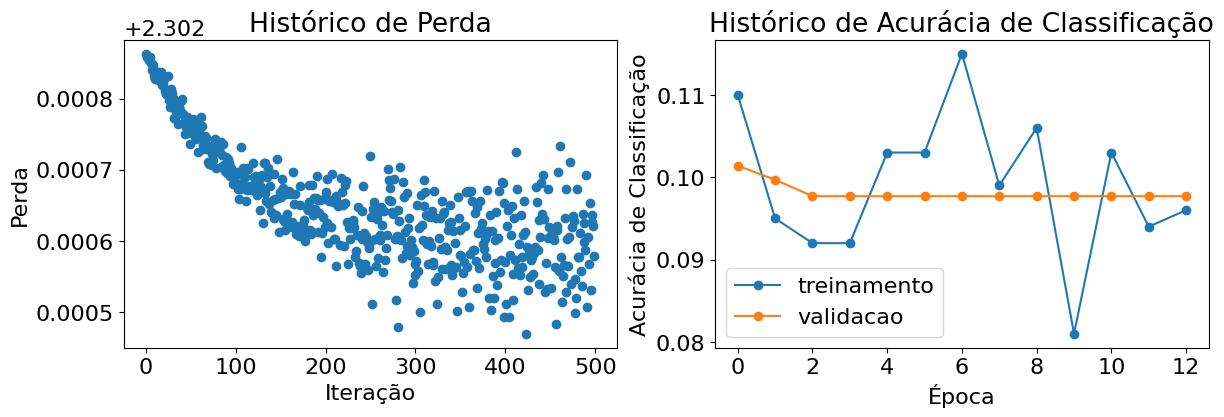

In [ ]:
# Plota a função de perda e as acurácias de treinamento / validação
from t2_auxiliares import plotar_estats

plotar_estats(estats)

Semelhante ao classificador SVM e Softmax, vamos visualizar os pesos.

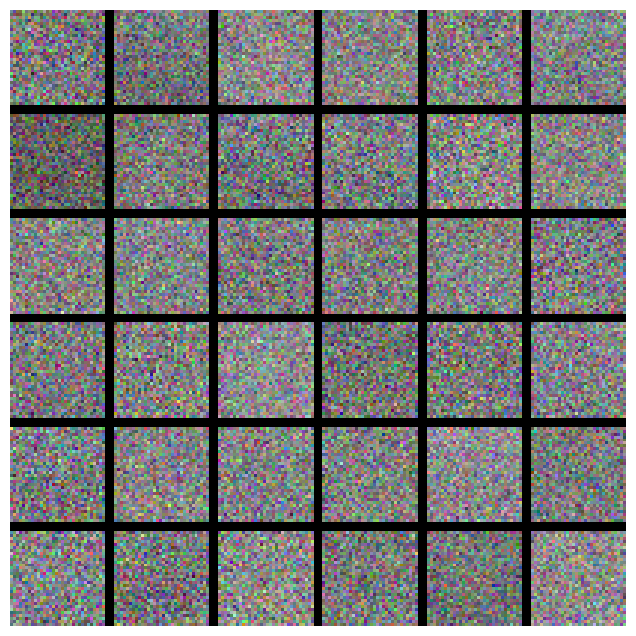

In [ ]:
from t2_auxiliares import mostrar_pesos_da_rede

mostrar_pesos_da_rede(rede)

### O que está errado?
Olhando para as visualizações acima, vemos que a perda está diminuindo mais ou menos linearmente, o que parece sugerir que a taxa de aprendizagem pode ser muito baixa. Além disso, não há diferença entre a acurácia de treinamento e de validação, sugerindo que o modelo que utilizamos tem baixa capacidade e que devemos aumentar seu tamanho. Por outro lado, com um modelo muito grande, esperaríamos ver mais sobreajuste, o que se manifestaria como uma diferença muito grande entre a acurácia de treinamento e de validação.

#### Capacidade?
Nosso modelo inicial tem desempenho muito semelhante nos conjuntos de treinamento e de validação. Isso sugere que o modelo é insuficiente e que seu desempenho pode melhorar se aumentarmos sua capacidade.

Uma maneira de aumentar a capacidade de um modelo de rede neural é aumentar o tamanho de sua camada oculta. Aqui, investigamos o efeito do aumento do tamanho da camada oculta. O desempenho (medido pela acurácia no conjunto de validação) deve aumentar à medida que o tamanho da camada oculta aumenta; no entanto, pode mostrar retornos decrescentes para tamanhos de camadas maiores.

treinamento com tamanho oculta: 2
treinamento com tamanho oculta: 8
treinamento com tamanho oculta: 32
treinamento com tamanho oculta: 128


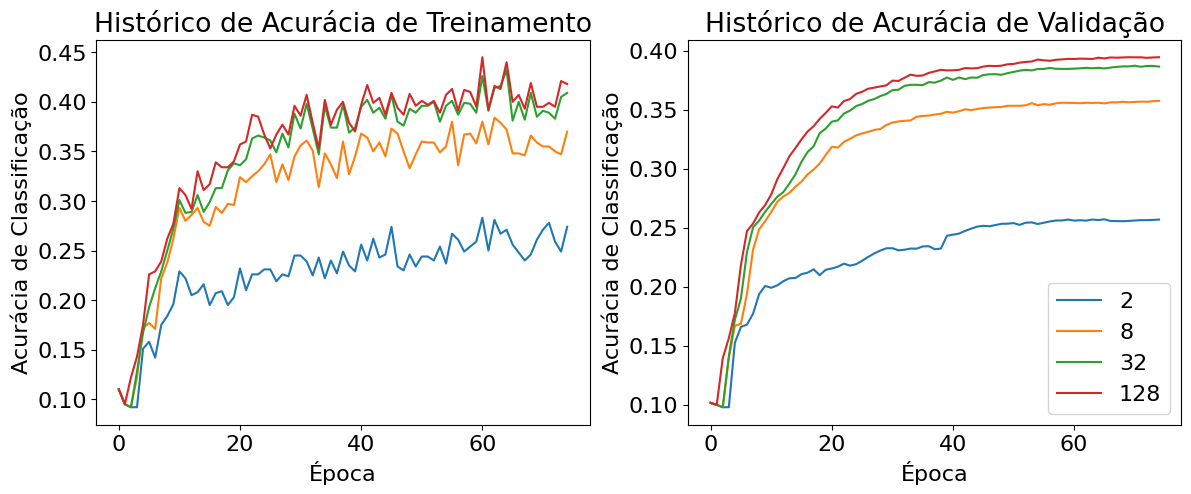

In [ ]:
import rv
from t2_auxiliares import plotar_curvas_de_acuracia
from rede_duas_camadas import RedeDuasCamadas

tamanhos_oculta = [2, 8, 32, 128]
tx_aprendizagem = 0.1
reg = 0.001

dic_estats = {}
for tam_oculta in tamanhos_oculta:
  print('treinamento com tamanho oculta: {}'.format(tam_oculta))
  # ajusta a semente aleatória antes de gerar um conjunto de parâmetros
  rv.redefinir_semente(0)
  rede = RedeDuasCamadas(3 * 32 * 32, tam_oculta, 10, device=dic_dados['X_treino'].device, dtype=dic_dados['X_treino'].dtype)
  estats = rede.treinar(dic_dados['X_treino'], dic_dados['y_treino'], dic_dados['X_val'], dic_dados['y_val'],
             num_iters=3000, tamanho_lote=1000,
             taxa_aprendizagem=tx_aprendizagem, decaimento_taxa_aprendizagem=0.95,
             reg=reg, verbose=False)
  dic_estats[tam_oculta] = estats

plotar_curvas_de_acuracia(dic_estats)

#### Regularização?
Outra possível explicação para a pequena diferença que vimos entre a acurácia de treinamento e de validação de nosso modelo é a regularização. Em particular, se o coeficiente de regularização for muito alto, o modelo pode ser incapaz de se ajustar aos dados de treinamento.

Podemos investigar o fenômeno empiricamente treinando um conjunto de modelos com forças de regularização variadas enquanto corrigimos outros hiperparâmetros.

Você deve ver que usar uma força de regularização muito alta prejudicará o desempenho do conjunto de validação do modelo:

treinamento com regularização: 0
treinamento com regularização: 1e-05
treinamento com regularização: 0.001
treinamento com regularização: 0.1


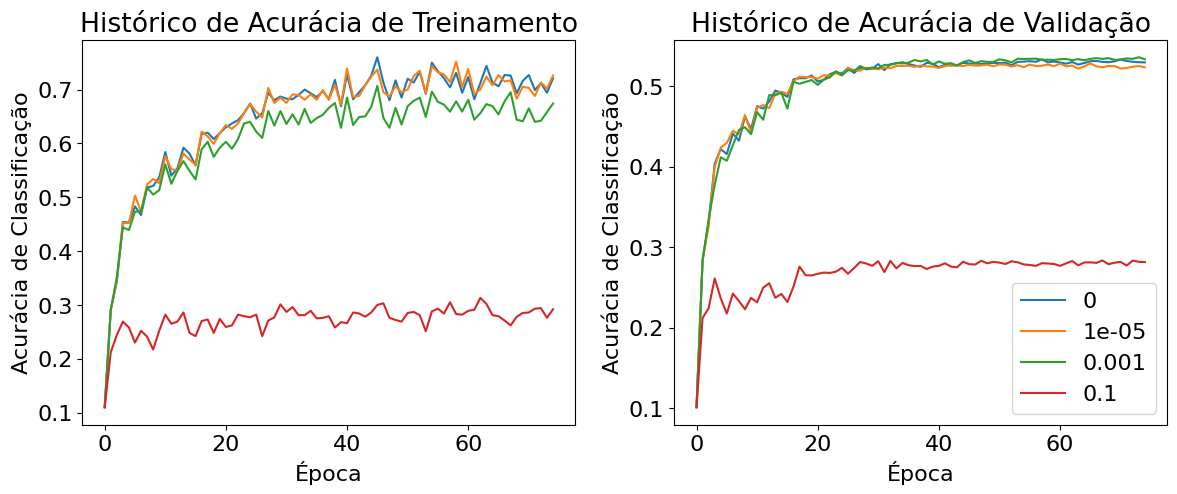

In [ ]:
import rv
from t2_auxiliares import plotar_curvas_de_acuracia
from rede_duas_camadas import RedeDuasCamadas

tam_oculta = 128
tx_aprendizagem = 1.0
regs = [0, 1e-5, 1e-3, 1e-1]

dic_estats = {}
for reg in regs:
  print('treinamento com regularização: {}'.format(reg))
  # ajusta a semente aleatória antes de gerar um conjunto de parâmetros
  rv.redefinir_semente(0)
  rede = RedeDuasCamadas(3 * 32 * 32, tam_oculta, 10, device=dic_dados['X_treino'].device, dtype=dic_dados['X_treino'].dtype)
  estats = rede.treinar(dic_dados['X_treino'], dic_dados['y_treino'], dic_dados['X_val'], dic_dados['y_val'],
             num_iters=3000, tamanho_lote=1000,
             taxa_aprendizagem=tx_aprendizagem, decaimento_taxa_aprendizagem=0.95,
             reg=reg, verbose=False)
  dic_estats[reg] = estats

plotar_curvas_de_acuracia(dic_estats)

#### Taxa de Aprendizagem?
Por último, mas não menos importante, também queremos ver o efeito da taxa de aprendizagem em relação ao desempenho.

treinamento com taxa de aprendizagem: 0.0001
treinamento com taxa de aprendizagem: 0.01
treinamento com taxa de aprendizagem: 1.0
treinamento com taxa de aprendizagem: 100.0


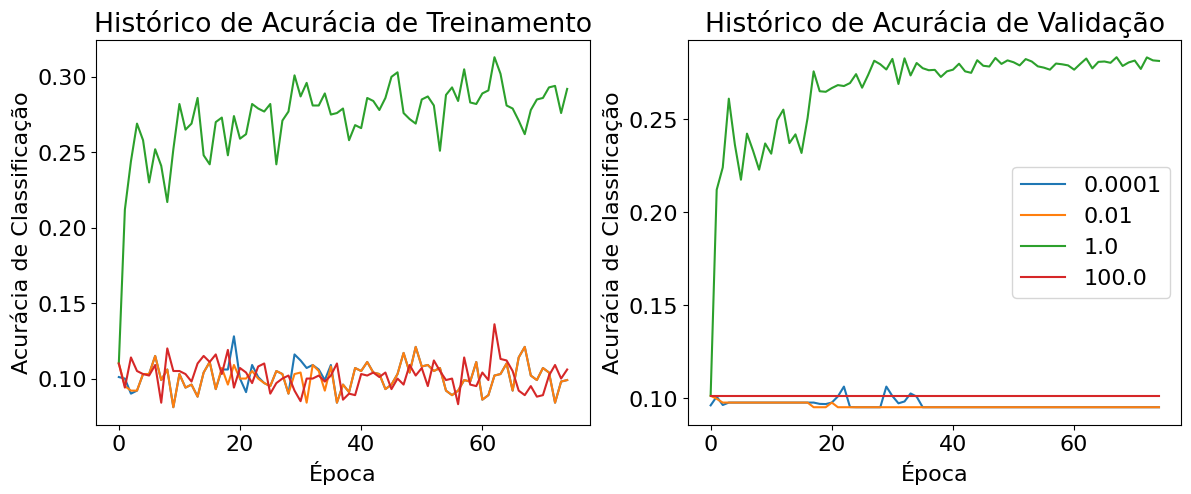

In [ ]:
import rv
from t2_auxiliares import plotar_curvas_de_acuracia
from rede_duas_camadas import RedeDuasCamadas

tam_oculta = 128
taxas_aprendizagem = [1e-4, 1e-2, 1e0, 1e2]
regs = 1e-4

dic_estats = {}
for tx_aprendizagem in taxas_aprendizagem:
  print('treinamento com taxa de aprendizagem: {}'.format(tx_aprendizagem))
  # ajusta a semente aleatória antes de gerar um conjunto de parâmetros
  rv.redefinir_semente(0)
  rede = RedeDuasCamadas(3 * 32 * 32, tam_oculta, 10, device=dic_dados['X_treino'].device, dtype=dic_dados['X_treino'].dtype)
  estats = rede.treinar(dic_dados['X_treino'], dic_dados['y_treino'], dic_dados['X_val'], dic_dados['y_val'],
             num_iters=3000, tamanho_lote=1000,
             taxa_aprendizagem=tx_aprendizagem, decaimento_taxa_aprendizagem=0.95,
             reg=reg, verbose=False)
  dic_estats[tx_aprendizagem] = estats

plotar_curvas_de_acuracia(dic_estats)

### Ajuste seus hiperparâmetros

**Ajuste**. Ajustar os hiperparâmetros e desenvolver a intuição de como eles afetam o desempenho final é uma grande parte do uso de Redes Neurais, portanto, queremos que você pratique bastante. Abaixo, você deve experimentar diferentes valores dos vários hiperparâmetros, incluindo tamanho da camada oculta, taxa de aprendizagem, número de épocas de treinamento e força de regularização. Você também pode considerar o fator de decaimento da taxa de aprendizagem, mas deve ser capaz de obter um bom desempenho usando o valor padrão.

**Gráficos**. Para orientar sua pesquisa de hiperparâmetros, você pode considerar fazer gráficos auxiliares de desempenho de treinamento e de validação como acima, ou plotar os resultados decorrentes de diferentes combinações de hiperparâmetros, como fizemos no exercício de Classificadores Lineares. Você deve se sentir à vontade para representar graficamente quaisquer resultados auxiliares necessários para encontrar uma boa rede, mas não será exigido nenhum gráfico específico de você.

**Resultados aproximados**. Para obter a nota máxima da tarefa, você deve atingir uma acurácia de classificação acima de 50% no conjunto de validação.

(Nosso melhor modelo obtém uma acurácia no conjunto de validação de 56.44% - você nos superou?)

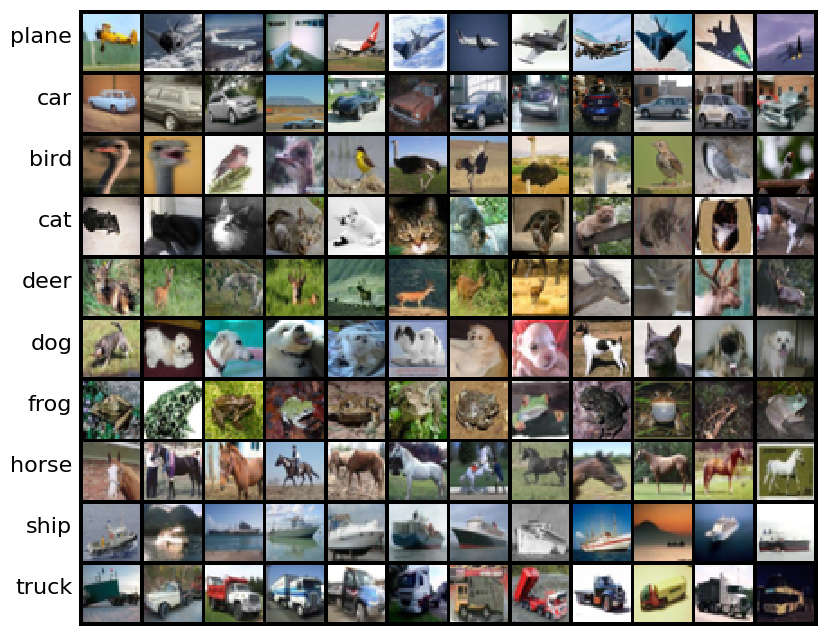

0.5496000051498413


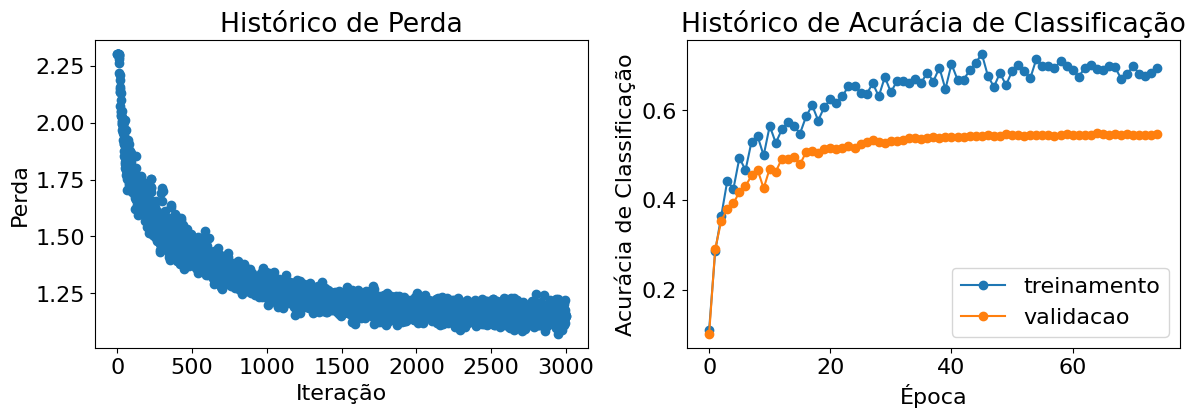

Salvo em drive/My Drive/RV-2022-2/T2/T2/melhor_modelo_rn.pt


In [ ]:
import os
import rv
from rede_duas_camadas import RedeDuasCamadas, encontrar_melhor_rede, rn_retorna_params_busca

# executar este modelo em float64 pode precisar de mais tempo, então defina-o como float32
rv.redefinir_semente(0)
dic_dados = rv.data.preprocessar_cifar10(dtype=torch.float32)

# armazene o melhor modelo aqui
rv.redefinir_semente(0)
melhor_rede, melhor_estat, melhor_acc_validacao = encontrar_melhor_rede(dic_dados, rn_retorna_params_busca)
print(melhor_acc_validacao)

plotar_estats(melhor_estat)

# salve o melhor modelo
path = os.path.join(GOOGLE_DRIVE_PATH, 'melhor_modelo_rn.pt')
melhor_rede.salvar(path)

In [ ]:
# Verifique a acurácia do conjunto de validação do seu melhor modelo
y_prev_validacao = melhor_rede.prever(dic_dados['X_val'])
acc_validacao = 100 * (y_prev_validacao == dic_dados['y_val']).double().mean().item()
print('Melhor acurácia no conjunto de validação: %.2f%%' % acc_validacao)

Melhor acurácia no conjunto de validação: 54.47%


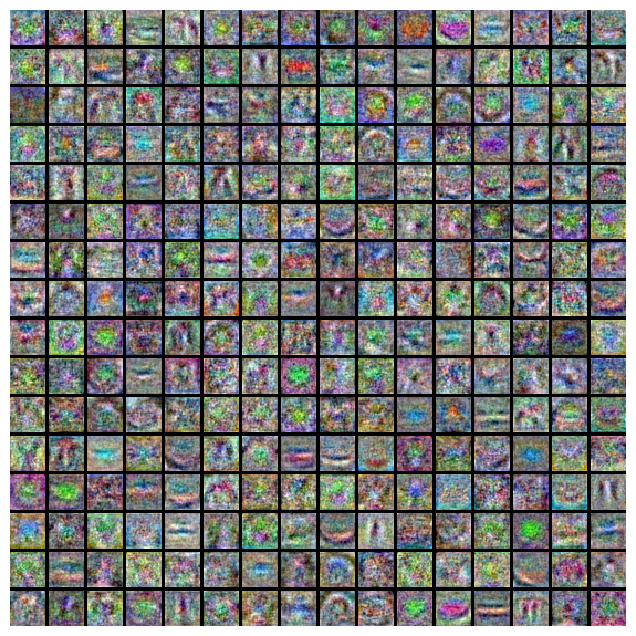

In [ ]:
from t2_auxiliares import mostrar_pesos_da_rede
# visualiza os pesos da melhor rede
mostrar_pesos_da_rede(melhor_rede)

### Execute no conjunto de teste
Quando terminar de experimentar, você deve avaliar sua rede no conjunto de teste. Para obter a nota máxima da tarefa, você deve atingir mais de 50% de acurácia de classificação no conjunto de teste.

(Nosso melhor modelo obtém 56.03% de acurácia no conjunto de teste - você nos superou?)

In [ ]:
y_prev_teste = melhor_rede.prever(dic_dados['X_teste'])
acc_teste = 100 * (y_prev_teste == dic_dados['y_teste']).double().mean().item()
print('Acurácia de teste: %.2f%%' % acc_teste)

Acurácia de teste: 54.26%


# Envie seu trabalho
Depois de concluir os dois notebooks para esta tarefa (`classificador_linear.ipynb` e este notebook, `rede_duas_camadas.ipynb`), execute a seguinte célula para criar um arquivo `.zip` para você baixar e entregar. **SALVE MANUALMENTE cada arquivo `*.ipynb` e `*.py` antes de executar a seguinte célula:**

In [6]:
from rv.submit import make_t2_submission

# TODO: Substitua-os pelo seu nome e RA
nome = 'Gabriel'
ra = 802430
make_t2_submission(GOOGLE_DRIVE_PATH, nome, ra)

ModuleNotFoundError: ignored